In [1]:
import pandas
import numpy as np

In [2]:
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score,StratifiedKFold,KFold
from sklearn.metrics import confusion_matrix,accuracy_score,silhouette_score#,calinski_harabaz_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest,f_classif,SelectFdr
from sklearn import svm
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize,RobustScaler,StandardScaler,MinMaxScaler

In [4]:
# read data
methy = pandas.read_csv("D:/1_Jie_OIO/pancreatic_cancer/input data/methylation2.csv")
mrna = pandas.read_csv("D:/1_Jie_OIO/pancreatic_cancer/input data/mrna.csv")
mirna = pandas.read_csv("D:/1_Jie_OIO/pancreatic_cancer/input data/mirna.csv")
clinical_new = pandas.read_csv("D:/1_Jie_OIO/pancreatic_cancer/clinical_data3.csv")
# 
clinical_new = clinical_new.drop(['Unnamed: 0'], axis = 1)
clinical_new = clinical_new[['bcr_patient_barcode','vital_status','survival']]

methy = methy.drop(['Unnamed: 0'], axis=1)
mrna = mrna.drop(['Unnamed: 0'], axis=1)
mirna = mirna.drop(['Unnamed: 0'], axis=1)

methy = methy.set_index(['Group.1'])
mrna = mrna.set_index(['Group.1'])
mirna = mirna.set_index(['GeneSymbol'])

methy = methy.transpose()
mrna = mrna.transpose()
mirna = mirna.transpose()

# data log2 transformation
mrna = np.log2(mrna+1)
mirna = np.log2(mirna+1)

In [5]:
# vital status has to be 0/1 not 1/2
clinical_new[["vital_status"]] = clinical_new[["vital_status"]] -1

data_all = pandas.concat([methy,mrna,mirna],axis = 1)
data_all2 = data_all.loc[clinical_new['bcr_patient_barcode'],:]
data_all2

,A1BG,A1BG-AS1,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AACSP1,...,hsa-mir-937,hsa-mir-939,hsa-mir-940,hsa-mir-942,hsa-mir-944,hsa-mir-95,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b
TCGA.2J.AAB6,0.392125,0.443796,0.470523,0.587413,0.730783,0.481929,0.401216,0.081614,0.631308,0.789943,...,1.659146,0.310120,1.764731,0.970296,0.565228,2.806379,4.812427,5.570562,8.939383,14.976723
TCGA.2J.AAB8,0.503784,0.657865,0.671000,0.747297,0.745571,0.465296,0.555999,0.065306,0.688562,0.773821,...,0.835161,1.121734,1.500529,1.565665,0.606636,2.512059,3.122654,5.361682,8.882110,13.226844
TCGA.2J.AAB9,0.407150,0.551150,0.607378,0.714571,0.774303,0.478354,0.558286,0.096926,0.702072,0.846118,...,0.282327,0.282327,0.898881,1.448498,1.199706,2.290066,3.169561,5.349524,9.336851,14.191277
TCGA.2J.AABA,0.537019,0.692183,0.677414,0.646668,0.744123,0.485663,0.528758,0.062211,0.670515,0.819271,...,0.000000,0.253555,0.469137,1.724951,0.656654,0.656654,1.724951,4.576809,10.267290,13.527318
TCGA.2J.AABE,0.485248,0.632153,0.649158,0.756352,0.739516,0.485606,0.497274,0.086935,0.647609,0.786354,...,1.158019,0.611445,0.434945,1.553472,0.768687,3.266121,3.463099,5.252521,9.104412,13.860464
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA.XD.AAUL,0.430066,0.616884,0.601854,0.727783,0.716007,0.465204,0.560235,0.068362,0.656267,0.788165,...,1.521978,0.501787,1.168577,2.367276,1.168577,1.521978,3.587736,5.772403,9.206623,13.619919
TCGA.XN.A8T3,0.389799,0.508017,0.622184,0.761291,0.710781,0.480178,0.544202,0.065075,0.669153,0.834831,...,0.761530,0.231214,1.148449,2.824518,2.751920,4.279853,4.506384,5.888266,9.208170,14.478188
TCGA.YB.A89D,0.505117,0.648158,0.712331,0.791110,0.744692,0.486454,0.604904,0.065248,0.662704,0.822138,...,0.143124,0.143124,0.701117,1.765008,0.955049,2.427698,3.676404,5.942291,10.096909,13.867643
TCGA.YY.A8LH,0.568815,0.737544,0.500254,0.773945,0.655661,0.541389,0.582060,0.084887,0.619335,0.862767,...,1.051422,0.689655,1.340416,1.721752,0.205673,2.833695,5.227565,6.105980,9.825959,14.498457


In [7]:
# class label
label_all = pandas.read_csv("D:/1_Jie_OIO/pancreatic cancer/class_label.txt")

In [6]:
label_all = [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
             1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
             1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
             1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
             1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
             1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
             0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]

australia pdac mrna

In [7]:
mrna_train = mrna.loc[clinical_new['bcr_patient_barcode'],:]
mirna_train = mirna.loc[clinical_new['bcr_patient_barcode'],:]
methy_train = methy.loc[clinical_new['bcr_patient_barcode'],:]

define functions

In [8]:
def single_omics(train_panel,label_all):
    #norm1
    train_panel1 = MinMaxScaler().fit_transform(train_panel.transpose()).transpose()
    train_panel1 = RobustScaler().fit_transform(train_panel1)            
        
    train_panel1 = pandas.DataFrame(train_panel1,columns = train_panel.columns) 

    mrna_f = [0]*30
    result = [0]*30

    svm_parameters = {
        'kernel': ['rbf','sigmoid','linear'],#,'rbf','sigmoid','poly','linear'
        'C': [0.001,0.005,0.01,0.05,0.1,0.5,0.75,1],#0.0001,0.0005,,0.25,0.5,0.75,1,1.25,1.5,1.75,2
        #'coef0': [0.001,0.005,0.01,0.05,0.1,0.25,0.5],#0.0005,0.01,,1.5,2,2.5
        #'degree' : [2,4,3],
        'gamma': [0.0001,0.001,0.01,0.1,0.25,0.5]}#0.001,0.0025,0.005,0.75,1,,1.2,1.5,2,2.2,2.5
    
    for n in range(5,155,5):
        i = int(n/5-1)
        # methy or mrna? K
        mrna_f[i] = SelectKBest(f_classif,k=n).fit_transform(train_panel1,label_all)
        #mrna_f[i] = train_panel1.loc[:,mirna_fea[0:k]].dropna(axis = 1)
        svm_tune = GridSearchCV(estimator=svm.SVC(kernel='rbf'),param_grid=svm_parameters,cv=3)#,iid = False,class_weight = 'balanced'
        #svm_tune.fit(mrna_f[i],label_all)
        svm_tune.fit(pandas.DataFrame(mrna_f[i]),label_all)
        
        result[i] = cross_val_score(svm_tune, mrna_f[i],label_all, cv=3).mean()

    # find maximum accuracy
    k_max = (result.index(max(result)) +1)*5
    print(k_max)
    
    omics_select = SelectKBest(f_classif,k = k_max).fit(train_panel1,label_all).get_support(indices = True)
    train_panel2 = train_panel1.iloc[:,omics_select]   

    print(train_panel2.columns)
    
    return train_panel2.columns, result

subtype predictor mRNA

In [119]:
# no fdr
prediction_mrna = single_omics(mrna_train,label_all)
predictor_all = prediction_mrna[0]
performance_feature = prediction_mrna[1]

120
Index(['ABCB1', 'ACKR1', 'ACSM5', 'ADAMTS8', 'ADCY5', 'ADGRB3', 'ANKRD55',
       'ANKS1B', 'ASPA', 'ASPH',
       ...
       'TMEM88', 'TNNT1', 'TPX2', 'TRPM6', 'UPK2', 'VIPR2', 'ZFP82', 'ZNF385D',
       'ZNF582', 'ZNF835'],
      dtype='object', name='Group.1', length=120)


In [130]:
performance_feature = prediction_mrna[1]
performance_feature

[0.7532596371882087,
 0.8289399092970521,
 0.86281179138322,
 0.86281179138322,
 0.8696145124716553,
 0.8765589569160998,
 0.8630952380952381,
 0.8493480725623582,
 0.8764172335600907,
 0.8424036281179138,
 0.8696145124716553,
 0.8764172335600907,
 0.8900226757369615,
 0.8900226757369615,
 0.8696145124716553,
 0.8626700680272109,
 0.8694727891156463,
 0.8833616780045351,
 0.8900226757369615,
 0.8832199546485261,
 0.8832199546485261,
 0.8696145124716553,
 0.86281179138322,
 0.8901643990929705,
 0.8832199546485261,
 0.8832199546485261,
 0.8697562358276644,
 0.8694727891156463,
 0.8901643990929705,
 0.8765589569160998,
 0.8561507936507936,
 0.8560090702947846,
 0.8901643990929705,
 0.8764172335600907,
 0.8560090702947846,
 0.862953514739229,
 0.8832199546485261,
 0.8901643990929705,
 0.8832199546485261,
 0.8764172335600907]

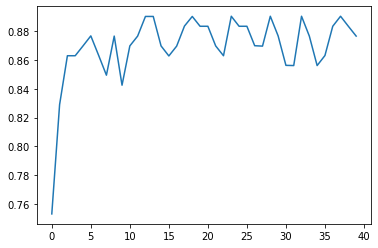

In [132]:
performance_feature = prediction[1]
plt.plot(performance_feature)

geo pdac mirna

In [157]:
# mirna predictor
mirna_train = mirna.loc[clinical_new['bcr_patient_barcode'],:]

120
Index(['hsa-let-7c', 'hsa-mir-101-1', 'hsa-mir-101-2', 'hsa-mir-10b',
       'hsa-mir-1179', 'hsa-mir-1224', 'hsa-mir-1247', 'hsa-mir-1248',
       'hsa-mir-125b-1', 'hsa-mir-125b-2',
       ...
       'hsa-mir-887', 'hsa-mir-889', 'hsa-mir-891a', 'hsa-mir-9-1',
       'hsa-mir-9-2', 'hsa-mir-92b', 'hsa-mir-934', 'hsa-mir-937',
       'hsa-mir-944', 'hsa-mir-99a'],
      dtype='object', name='GeneSymbol', length=120)


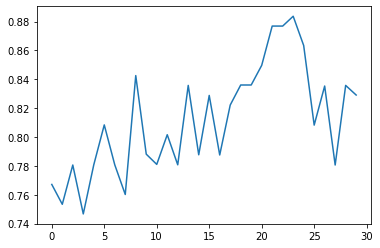

In [160]:
prediction_mirna = single_omics(mirna_train,label_all)
predictor_mirna = prediction_mirna[0]
performance_feature = prediction_mirna[1]
# 120 miRNA
plt.plot(performance_feature)

australia pdac methylation

90
Index(['ADAMTS20', 'ADGRF4', 'ARL14', 'C14orf39', 'C5orf38', 'DEFB135',
       'DKFZP434H168', 'DLX5', 'DLX6AS', 'EVX2', 'FAM25A', 'FOXG1', 'GAD1',
       'GDPD4', 'GORASP2', 'HBB', 'HOXA7', 'HOXA9', 'HOXD8', 'HRH1', 'IRX2',
       'ITGA4', 'LOC729384', 'LOC91450', 'MIR1200', 'MIR1249', 'MIR129-2',
       'MIR137', 'MIR663A', 'MMP13', 'MSX1', 'NETO1', 'NKX2-4', 'NPFFR1',
       'NRN1', 'ODAPH', 'OR10J3', 'OR10S1', 'OR2T4', 'OR8D2', 'OR8G1', 'OR8G5',
       'PAX9', 'PCDHB15', 'PCDHGA1', 'PCDHGA10', 'PCDHGA11', 'PCDHGA12',
       'PCDHGA2', 'PCDHGA3', 'PCDHGA4', 'PCDHGA5', 'PCDHGA6', 'PCDHGA7',
       'PCDHGA8', 'PCDHGA9', 'PCDHGB1', 'PCDHGB2', 'PCDHGB3', 'PCDHGB4',
       'PCDHGB5', 'PCDHGB6', 'PCDHGB7', 'PCDHGC4', 'PENK', 'PI3', 'PITX2',
       'PLET1', 'POLR1A', 'POU3F3', 'PRDM8', 'RPL23AP82', 'RTL9', 'RYK',
       'SFT2D3', 'SIRPG', 'SIX2', 'SLURP1', 'SNORD114-18', 'SNORD114-19',
       'SRPX2', 'SULT1C4', 'TBR1', 'TRIP13', 'TTLL1', 'WT1-AS', 'ZFP42',
       'ZIC1', 'ZNF154', 'ZNF

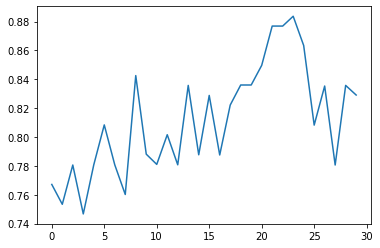

In [166]:
prediction_methy2 = single_omics(methy_train,label_all)
predictor_methy2 = prediction_methy2[0]
performance_feature2 = prediction_methy2[1]
# 
plt.plot(performance_feature)

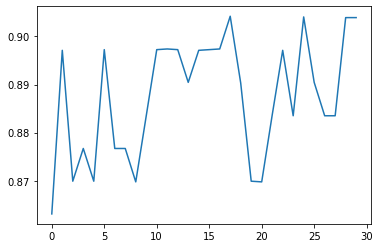

In [168]:
plt.plot(performance_feature2)